In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

random_seed = 12

import os
mlflow_tracking_uri = os.path.join(os.path.dirname(os.getcwd()), 'mlruns')
print(f"MLflow tracking URI: {mlflow_tracking_uri}")

# Change to \\ if on Windows
if os.name == 'nt':
    mlflow.set_tracking_uri(f"file:\\{mlflow_tracking_uri}")
else:
    mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

mlflow.end_run()
mlflow.set_experiment("classification_models")

MLflow tracking URI: /Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/mlruns


<Experiment: artifact_location='file:///Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/mlruns/121870725887573685', creation_time=1761752874096, experiment_id='121870725887573685', last_update_time=1761752874096, lifecycle_stage='active', name='classification_models', tags={}>

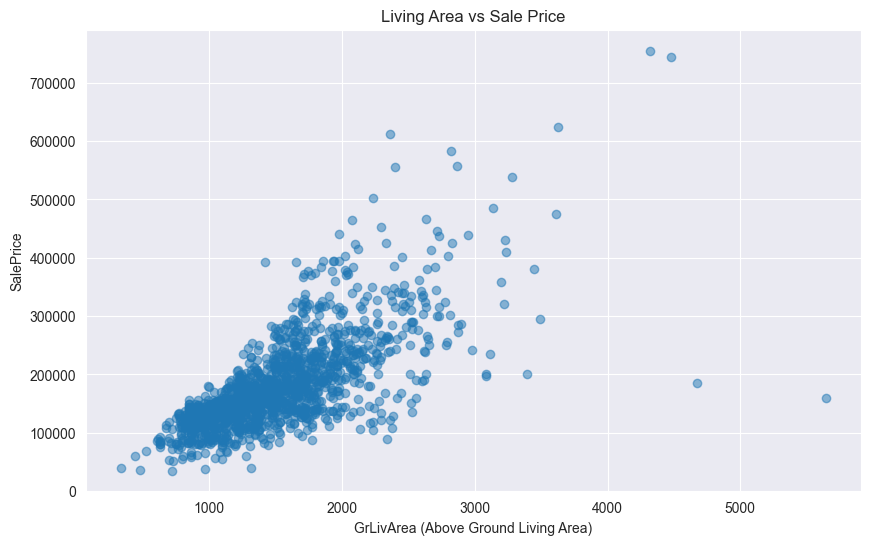

In [11]:
df = pd.read_csv('../data/train.csv')

# Plot to see if there are any obvious outliers (e.g., very large GrLivArea with low SalePrice)
plt.figure(figsize=(10, 6))
plt.scatter(df['GrLivArea'], df['SalePrice'], alpha=0.5)
plt.xlabel('GrLivArea (Above Ground Living Area)')
plt.ylabel('SalePrice')
plt.title('Living Area vs Sale Price')

outliers_index = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index
df = df.drop(outliers_index)
df = df.reset_index(drop=True)

In [12]:
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1458, 79)
Target shape: (1458,)


In [13]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

In [14]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Size after preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(f"Preprocessed training data shape: {X_train_preprocessed.shape}")

# Fit preprocessor once on training data to avoid data leakage
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


Preprocessed training data shape: (1166, 296)


In [15]:
mlflow.set_experiment("Regression_NN")
mlflow.start_run(run_name="regression_nn_gridsearch")

# Initial params
mlflow.log_param("random_seed", random_seed)
mlflow.log_param("test_size", 0.2)
mlflow.log_param("activation", "relu")
mlflow.log_param("solver", "adam")
mlflow.log_param("max_iter", 500)
mlflow.log_param("early_stopping", True)

# Grid Search to find the best set of hidden layer sizes
mlp_for_grid = MLPRegressor(
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=random_seed,
    early_stopping=True,
    n_iter_no_change=20,
    verbose=False
)

param_grid = {
    'hidden_layer_sizes': [
        (296, 150,),
        (296, 150, 75, 25),
        (100, 50, 25,),
    ],
}

grid_search = GridSearchCV(
    mlp_for_grid,
    param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
)

grid_search.fit(X_train_preprocessed, y_train)

print("Best parameters:", grid_search.best_params_)

# Log best parameters
mlflow.log_param("best_hidden_layer_sizes", str(grid_search.best_params_['hidden_layer_sizes']))
mlflow.log_metric("best_cv_score", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Best parameters: {'hidden_layer_sizes': (296, 150, 75, 25)}


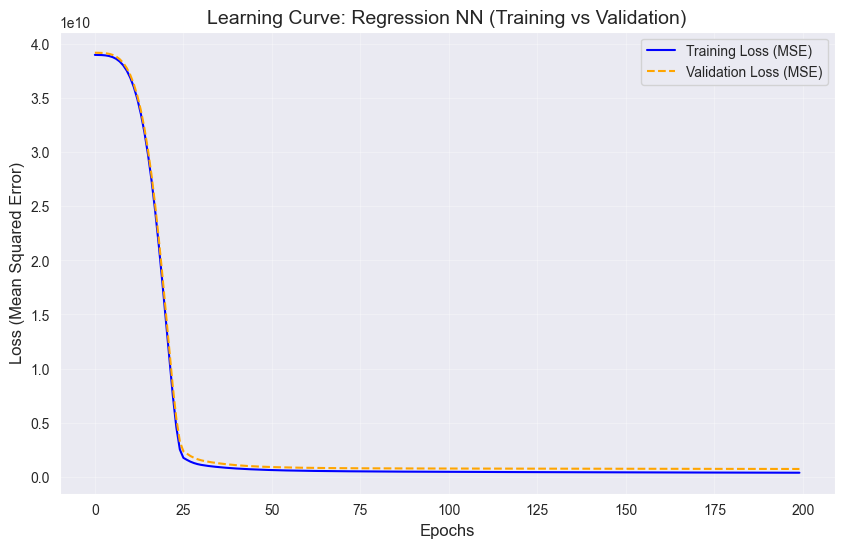

In [16]:
best_params = grid_search.best_params_

mlp_model_to_use = MLPRegressor(
    **best_params,
    max_iter=1,
    warm_start=True,     # Preserve weights between calls
    random_state=random_seed,
    verbose=False
)

train_loss_history = []
val_loss_history = []

n_epochs = 200
mlflow.log_param("n_epochs", n_epochs)

for epoch in range(n_epochs):
    mlp_model_to_use.fit(X_train_preprocessed, y_train)

    # Training MSE
    y_train_pred_mon = mlp_model_to_use.predict(X_train_preprocessed)
    train_mse_mon = mean_squared_error(y_train, y_train_pred_mon)
    train_loss_history.append(train_mse_mon)

    # Validation MSE (using X_test as validation here)
    y_test_pred_mon = mlp_model_to_use.predict(X_test_preprocessed)
    val_mse_mon = mean_squared_error(y_test, y_test_pred_mon)
    val_loss_history.append(val_mse_mon)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss (MSE)', color='blue')
plt.plot(val_loss_history, label='Validation Loss (MSE)', color='orange', linestyle='--')

plt.title('Learning Curve: Regression NN (Training vs Validation)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

mlflow.log_figure(plt.gcf(), 'plot2.png')

plt.show()

In [17]:
# Use the trained model for predictions
y_train_pred = best_model.predict(X_train_preprocessed)
y_test_pred = best_model.predict(X_test_preprocessed)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Log metrics to MLFlow
mlflow.log_metric("train_rmse", train_rmse)
mlflow.log_metric("train_mae", train_mae)
mlflow.log_metric("train_r2", train_r2)
mlflow.log_metric("test_rmse", test_rmse)
mlflow.log_metric("test_mae", test_mae)
mlflow.log_metric("test_r2", test_r2)

# Log the model
mlflow.sklearn.log_model(best_model, "model")

print("-"*40)
print("Training Set Performance:")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE: {train_mae:.2f}")
print(f"R²: {train_r2:.4f}")
print("-"*40)
print("Test Set Performance:")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.4f}")
print("-"*40)

2025/11/21 18:04:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/21 18:04:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


----------------------------------------
Training Set Performance:
RMSE: 21509.39
MAE: 14126.47
R²: 0.9245
----------------------------------------
Test Set Performance:
RMSE: 25270.25
MAE: 16852.56
R²: 0.9097
----------------------------------------


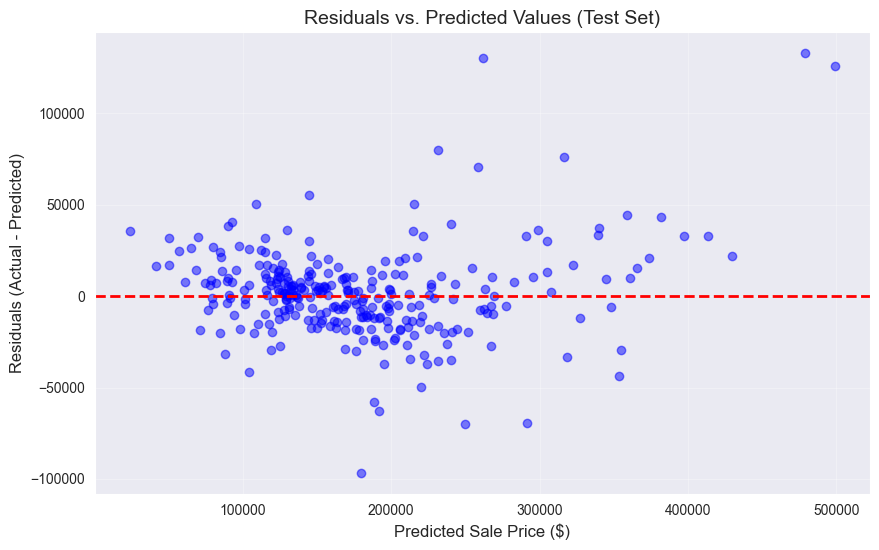

In [18]:
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5, color='blue')

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs. Predicted Values (Test Set)', fontsize=14)
plt.xlabel('Predicted Sale Price ($)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True, alpha=0.3)

mlflow.log_figure(plt.gcf(), 'residuals_plot.png')

plt.show()

mlflow.end_run()